# Behavorial-Cloning Project
## - Brian Erickson
This is my implementation of the Udacity Self Driving Car class project "Behavioral Cloning".

The goal is to record driving input and images using a driving simulator, use the recorded input and images to train a neural network that will predict steering angles and then use the predicted steering angles to drive the same car in the same simulator.

Installation: This is a linux based implementation.  The linux simulator should be installed in ../simulator

### Imports and Helper Functions

The helper functions below will be used throughout the notebook.

In [77]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import math
import time
import skimage.transform
import random
import os
from ipywidgets import widgets
from IPython.display import display
import keras
%matplotlib inline

In [78]:
# to make "random" calls predictable, use a fixed seed
# since I'm using random from  numpy, tensorflow and from the 
# standard python random, I have a single seed helper
# that will take care of all
def seed(n=32568):
    """
    Seeds the random number generators
    """
    np.random.seed(n)
    random.seed(n)
    tf.set_random_seed(n)



In [79]:
# from http://stackoverflow.com/a/27681394/383967, modified
def running_mean(x, n):
    x=np.array(x)
    rv = pd.rolling_mean(x, n, center=True)
    # fill the na on the boundaries
    for i in range(n):
        if not math.isnan(rv[i]):
            rv[:i]=rv[i]
            break
    for i in range(1,n):
            if not math.isnan(rv[-i]):
                rv[-i:]=rv[-i]
                break            
    return rv
    
    #cumsum = np.cumsum(np.insert(x, 0, 0)) 
    #return (cumsum[N:] - cumsum[:-N]) / N 

In [80]:
def smooth2(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[window_len//2:x.size+window_len//2]

100 100


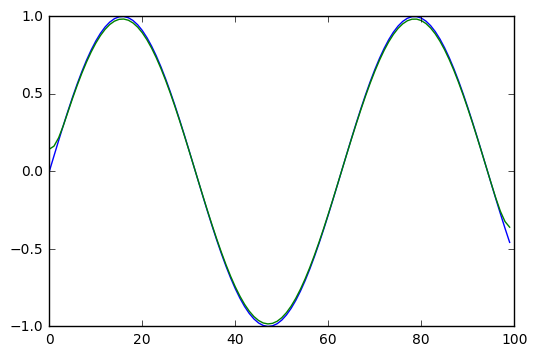

In [81]:
a = np.arange(100)
a=np.sin(a/10.)
#running_mean(a,3)
plt.plot(a)
plt.plot(smooth2(np.array(a)))
print(len(a),len(smooth2(np.array(a))))

In [82]:
def plot_image(img,title=None):
    '''
    Plots a single RGB or Greyscale image with no border
    '''
    cmap = 'gray' if np.ndim(img) == 2 else None
    plt.axis('off')
    plt.imshow(img, cmap=cmap, interpolation='none')
    if title is not None:
        plt.title(title)
        
def plot_images(l, images_per_line = 10, image_size_inches = 1.0, title=None):
    """
    Plots images in a grid
    """
    fig=plt.figure()
    if title is not None:
        fig.suptitle(title)
    line_count=math.ceil(len(l)/images_per_line)
    fig.set_size_inches(w=images_per_line*image_size_inches,h=line_count*image_size_inches)
    for i in range(len(l)):
        img=l[i]
        plt.subplot(line_count,10,i+1)
        plot_image(img)


In [83]:
def random_sample(*lists, n=None, random_order=True):
    """
    Returns parallel lists with n random samples from lists without replacement
    """
    list_count = len(lists)
    list_length = len(lists[0])
    #print(list_count,list_length)
    if n is None:
        n = list_length
    if n > list_length:
        n = list_length
    indexes = list(range(list_length))
    np.random.shuffle(indexes)
    indexes = indexes[:n]
    if random_order == False:
        indexes.sort()
    rv = [ [l[i] for i in indexes] for l in lists]
    if list_count==1:
        rv = rv[0]
    return rv
        

In [84]:
def split(*lists,n=None,ratio=None):
    if ratio is not None:
        n=int(len(lists[0])*ratio)
    rv = []
    for l in lists:
        rv.append(l[:n])
        rv.append(l[n:])
    return rv

### Simulator Execution
I enable manual simulator execution by adding a button to this notebook.  If everything is installed correctly, clicking the button will launch the simulator to allow you to manually collect training data.  After this is done once, you can use the training data throughout this notebook.

In [85]:
def run_simulator(b):
    !"../simulator/Default Linux desktop Universal.x86_64">/dev/null

def show_run_simulator_button():
    simulator_button = widgets.Button(description= "Run Simulator")
    simulator_button.on_click(run_simulator)
    display(simulator_button)

show_run_simulator_button()

In [86]:
def run_drive(b):
    !"python drive.py model.json"

def show_drive_button():
    drive_button = widgets.Button(description= "Drive")
    drive_button.on_click(run_drive)
    display(drive_button)

show_drive_button()


In [87]:
def read_driving_log(folder='recordings'):
    csv_path = folder+'/driving_log.csv'
    csv_column_names = [
        'center',
        'left',
        'right',
        'steering',
        'throttle',
        'brake',
        'speed']
    
    return pd.read_csv(csv_path)

driving_log = read_driving_log('sample_data')
                    


Here I show the first few rows of the log, we see that for each entry, there is a left, right, and center image as well as the conrol inputs and speed.  We will mainly be concentrating on the steering angle and center_image_path as these are designed to be the inputs and outputs of the system.

In [88]:
driving_log.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


In [89]:
center_sample, steering_sample = random_sample(
    driving_log.center.values,
    driving_log.steering.values,
    #n=4000,
    random_order=False)

In [90]:
(1,2,3)[0]

1

In [91]:
def process_image(im):
    new_size=(im.shape[1]//2,im.shape[0]//2)
    small=cv2.resize(im,(new_size),interpolation=cv2.INTER_AREA)
    return  (cv2.cvtColor(small,cv2.COLOR_RGB2YUV).astype(float) - 128.)/255.


In [92]:
images=[]
for path in center_sample:
    im = plt.imread('sample_data//'+path)
    im=process_image(im)
    images.append(im)
    
center_images = np.array(images,dtype='float')
del images

steering_angles = steering_sample

In [93]:
np.min(center_images[0,:,:,:])

-0.50196078431372548

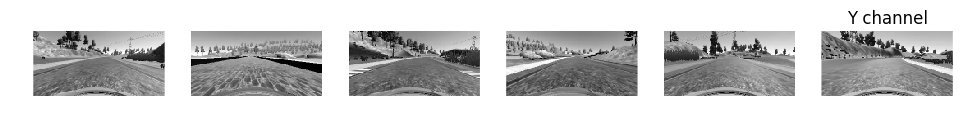

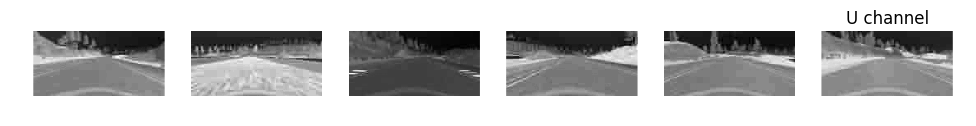

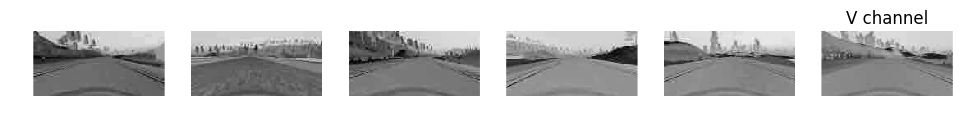

In [94]:

seed()
sample_images = np.array(random_sample(center_images,n=6))
plot_images(sample_images[:,:,:,0],image_size_inches=2)
plt.title("Y channel")
seed()
plot_images(sample_images[:,:,:,1],image_size_inches=2)
plt.title("U channel")
seed()
plot_images(sample_images[:,:,:,2],image_size_inches=2)
plt.title("V channel")

In [95]:
def show_run_simulator_button():
    simulator_button = widgets.Button(description= "Run Simulator")
    simulator_button.on_click(run_simulator)
    display(simulator_button)

show_run_simulator_button()

used this as a starter: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [96]:
X=center_images


In [97]:
#X = np.moveaxis(X,(0,1,2,3),(0,2,3,1))
y=np.array(steering_angles)
y=smooth2(y) #smooth the output
X_train,X_val=split(X,ratio=0.8)
y_train,y_val=split(y,ratio=0.8)
X_train=np.array(X_train)
X_val=np.array(X_val)
y_train=np.array(y_train)
y_val=np.array(y_val)

In [98]:
print(np.shape(X_train), np.shape(y_train), np.shape(X_val), np.shape(y_val))
X_train_r,y_train_r = random_sample(X_train,y_train)
X_train_r = np.reshape(X_train_r,X_train.shape)
y_train_r = np.reshape(y_train_r,y_train.shape)
print(np.shape(X_train_r), np.shape(y_train_r))



(6428, 80, 160, 3) (6428,) (1608, 80, 160, 3) (1608,)
(6428, 80, 160, 3) (6428,)


In [99]:
im_shape = X_train[0].shape
print(im_shape)

(80, 160, 3)


In [100]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


In [101]:
# %load model.py
# manually transcribed and modified from 
# https://chatbotslife.com/learning-human-driving-behavior-using-nvidias-neural-network-model-and-image-augmentation-80399360efee#.u8zq6ghon
from keras.layers import Lambda, Convolution2D, SeparableConvolution2D, Dense
from keras.activations import relu, elu
def RELU():
    return Activation(elu)

def nvidia_model(input_shape):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 -1., input_shape = input_shape))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal", dim_ordering='tf'))
    model.add(RELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal", dim_ordering='tf'))
    model.add(RELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal", dim_ordering='tf'))
    model.add(RELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal", dim_ordering='tf'))
    model.add(RELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal", dim_ordering='tf'))
    model.add(Flatten())
    model.add(RELU())
    model.add(Dense(1164, init="he_normal"))
    model.add(RELU())
    model.add(Dense(100, init="he_normal"))
    model.add(RELU())
    model.add(Dense(50, init="he_normal"))
    model.add(RELU())
    model.add(Dense(10, init="he_normal"))
    model.add(RELU())
    model.add(Dense(1, init="he_normal"))
    return model



In [102]:
def model_a(im_shape):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=im_shape))
    model.add(SeparableConvolution2D(16, 3,3,  border_mode='valid', subsample=(2,2),activation='relu',name='conv1', dim_ordering='tf'))
    model.add(Convolution2D(32, 3, 3, border_mode='valid',  subsample=(2,2), activation='relu',name='conv2', dim_ordering='tf'))
    #model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
    model.add(Convolution2D(8, 5, 5, border_mode='valid', activation='relu',name='conv3', dim_ordering='tf'))
    model.add(MaxPooling2D(pool_size=(4, 4), name ='maxpool2'))
    model.add(Flatten())
    model.add(Dense(20,activation='sigmoid',name='dense1'))
    model.add(Dropout(0.5, name ='dropout'))
    model.add(Dense(20,activation='sigmoid', name = 'dense2'))
    model.add(Dense(1,activation='linear', name = 'final'))
    return model

In [111]:
model = model_a(im_shape)
#model = nvidia_model(im_shape)
#model.compile(loss='mean_absolute_error', optimizer='adam')
model.compile(loss='mse', optimizer='adam')

In [112]:

history = model.fit(X_train_r, y_train_r,
#history = model.fit(X, y,
          nb_epoch=80, batch_size=46,
          validation_data=(X_val, y_val))


Train on 6428 samples, validate on 1608 samples
Epoch 1/80
6428/6428 [==============================] - 10s - loss: 0.0900 - val_loss: 0.0241
Epoch 2/80
6428/6428 [==============================] - 9s - loss: 0.0281 - val_loss: 0.0219
Epoch 3/80
6428/6428 [==============================] - 9s - loss: 0.0184 - val_loss: 0.0160
Epoch 4/80
6428/6428 [==============================] - 9s - loss: 0.0132 - val_loss: 0.0120
Epoch 5/80
6428/6428 [==============================] - 9s - loss: 0.0110 - val_loss: 0.0112
Epoch 6/80
6428/6428 [==============================] - 9s - loss: 0.0097 - val_loss: 0.0106
Epoch 7/80
6428/6428 [==============================] - 9s - loss: 0.0092 - val_loss: 0.0098
Epoch 8/80
6428/6428 [==============================] - 9s - loss: 0.0089 - val_loss: 0.0098
Epoch 9/80
6428/6428 [==============================] - 9s - loss: 0.0086 - val_loss: 0.0097
Epoch 10/80
6428/6428 [==============================] - 9s - loss: 0.0084 - val_loss: 0.0088
Epoch 11/80
6428/642

In [113]:
y_train_predict=model.predict(X_train)
print(max(y_train), min(y_train), max(y_train_predict), min(y_train_predict))
print(np.mean(y_train),np.mean(y_train_predict))


0.436672429724 -0.527898638182 [ 0.30387408] [-0.30905321]
0.0141904324871 0.0224912


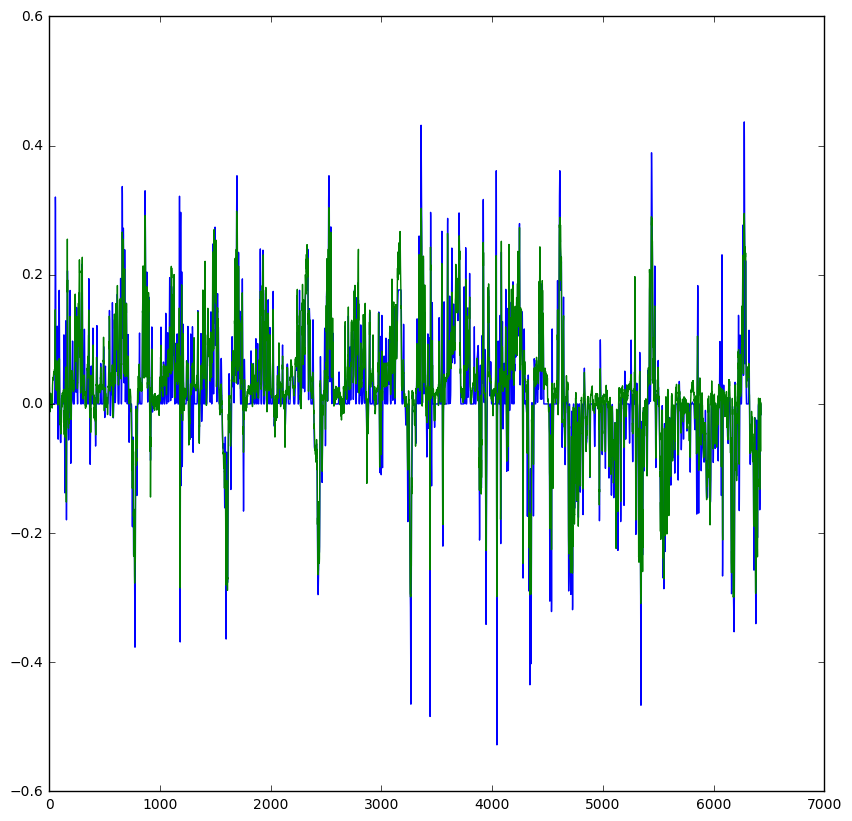

In [114]:

plt.figure(figsize=(10,10))
plt.plot(y_train,color='b')
#plt.plot(running_mean(y_train,8),color='k')
plt.plot(y_train_predict,color='g')

#print(len(y_train),len(running_mean(y_train,10)))

#plt.plot(model.predict(X_val),color='r')

In [115]:
y_val_predict = model.predict(X_val)

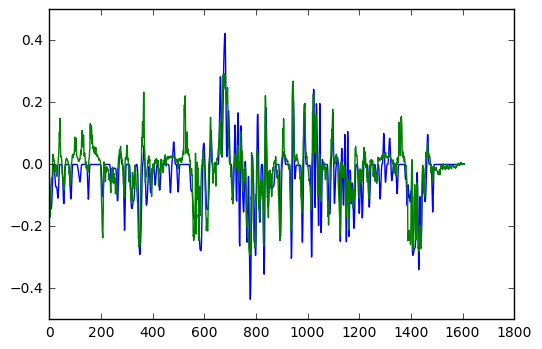

In [116]:
plt.plot(y_val, color='b')
plt.plot(y_val_predict, color='g')


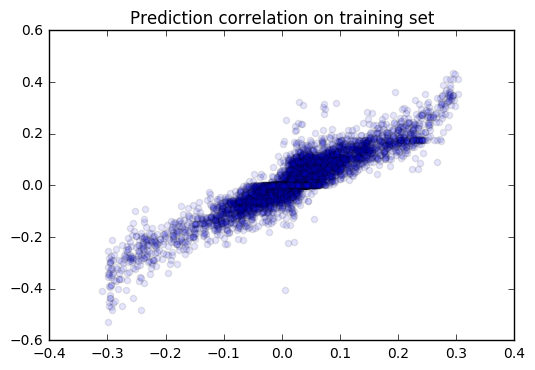

In [117]:
plt.scatter(y_train_predict,y_train,alpha=0.1)
plt.title("Prediction correlation on training set")

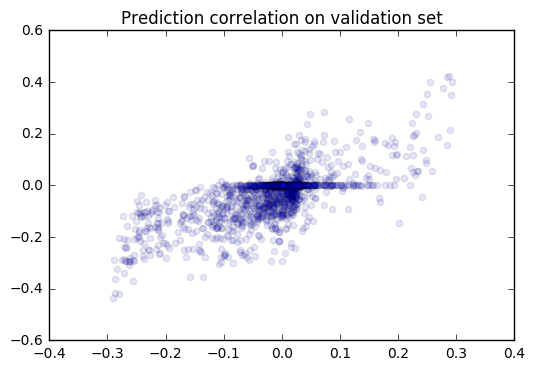

In [118]:
plt.scatter(y_val_predict,y_val,alpha=0.1)
plt.title("Prediction correlation on validation set")

In [119]:
#model.save('model_a_v00304.h5')
def save_model_to_json(model, file_path='model.json'):
    json = model.to_json()
    with open(file_path, 'w') as f:
        f.write(json)
        
def save_weights(model, file_path='model.h5'):
    model.save_weights(file_path)

def save_all():
    save_model_to_json(model)
    save_weights(model)



In [120]:
save_all()